## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(512),
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512),
            nn.ReLU(512),
            nn.Linear(512, 128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(128),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
# torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

Your experiments come here:

In [9]:
def train(dataloader, model, loss_func, optimizer):
    '''Train model'''
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()
    
    for batch_idx, (X_data, y_data) in enumerate(dataloader):
        X_data = X_data.to(device)
        y_data = y_data.to(device)
        
        # Forward
        pred = model(X_data)
        loss = loss_func(pred, y_data)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss_func(pred, y_data).item()
        correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
        
    train_loss /= size
    correct /= size
    
    return correct, train_loss
            
def test(dataloader, model, loss_func):
    '''Test accuracy'''
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X_data, y_data in dataloader:
            X_data = X_data.to(device)
            y_data = y_data.to(device)
            pred = model(X_data)
            test_loss += loss_func(pred, y_data).item()
            correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    
    return correct, test_loss

def plot_data(data: list, title: str, legend: list, xlabel: str, ylabel: str) -> None:
    '''Plot data from list'''
    plt.title(title)
    plt.grid()

    for data_item in data:
        x_range_lst = list(range(len(data_item)))
        plt.plot(x_range_lst, data_item)
        
    plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [10]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [11]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 40
for t in range(epochs):
    train_accuracy, train_loss = train(train_loader, model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(test_loader, model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
        Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

Epoch: 1	Test Accuracy: 80.5%, Test Avg loss: 0.002640	        Train Accuracy: 73.4%, Train Avg loss: 0.007817
Epoch: 2	Test Accuracy: 83.2%, Test Avg loss: 0.001813	        Train Accuracy: 83.7%, Train Avg loss: 0.003563
Epoch: 3	Test Accuracy: 83.9%, Test Avg loss: 0.001729	        Train Accuracy: 85.8%, Train Avg loss: 0.003077
Epoch: 4	Test Accuracy: 85.6%, Test Avg loss: 0.001570	        Train Accuracy: 86.9%, Train Avg loss: 0.002828
Epoch: 5	Test Accuracy: 86.0%, Test Avg loss: 0.001531	        Train Accuracy: 87.5%, Train Avg loss: 0.002674
Epoch: 6	Test Accuracy: 85.2%, Test Avg loss: 0.001588	        Train Accuracy: 88.1%, Train Avg loss: 0.002541
Epoch: 7	Test Accuracy: 86.6%, Test Avg loss: 0.001448	        Train Accuracy: 88.7%, Train Avg loss: 0.002430
Epoch: 8	Test Accuracy: 86.7%, Test Avg loss: 0.001446	        Train Accuracy: 89.0%, Train Avg loss: 0.002348
Epoch: 9	Test Accuracy: 86.2%, Test Avg loss: 0.001493	        Train Accuracy: 89.4%, Train Avg loss: 0.002267
E

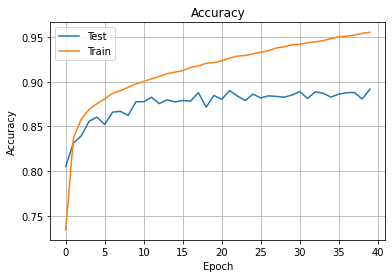

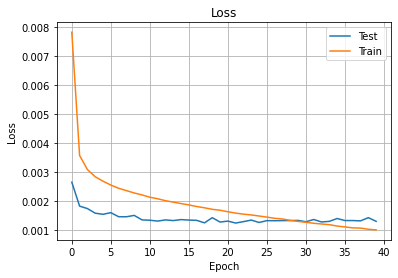

In [12]:
plot_data(
    data=[test_accuracy_lst, train_accuracy_lst],
    title="Accuracy",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Accuracy"
)
plot_data(
    data=[test_loss_lst, train_loss_lst],
    title="Loss",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Loss"
)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Для переобученя модели
1) отключим L2 регуляризацию 
2) Не используем Dropout слои
3) Используем только 0.25 тренировочного датасета
4) Используем модель с большим числом слоев и параметров (выше было показано, что модель может давать желаемый результат и с меньшим числом параметров)

Rem: Слои с Batchnorm пришлось добавить сразу, а не в разделе Fix it, т.к. без них модель очень плохо обучалась.

In [59]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Linear(2048, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [60]:
def train(dataloader, model, loss_func, optimizer):
    '''Train model'''
    max_batch_count = len(dataloader) / 4
    batch_size = 128
    size = int(batch_size * max_batch_count)
    train_loss, correct = 0, 0
    model.train()
    
    for batch_idx, (X_data, y_data) in enumerate(dataloader):
        if batch_idx >= max_batch_count:
            break
        X_data = X_data.to(device)
        y_data = y_data.to(device)
        
        # Forward
        pred = model(X_data)
        loss = loss_func(pred, y_data)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss_func(pred, y_data).item()
        correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
        
    train_loss /= size
    correct /= size
    
    return correct, train_loss

In [61]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0)
loss_func = nn.CrossEntropyLoss()

In [62]:
# torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

In [58]:
len(train_loader.dataset) / len(train_loader)

127.9317697228145

In [63]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 500
for t in range(epochs):
    train_accuracy, train_loss = train(train_loader, model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(test_loader, model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
        Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

Epoch: 1	Test Accuracy: 75.1%, Test Avg loss: 0.003481	        Train Accuracy: 65.8%, Train Avg loss: 0.009944
Epoch: 2	Test Accuracy: 78.5%, Test Avg loss: 0.002763	        Train Accuracy: 78.3%, Train Avg loss: 0.006000
Epoch: 3	Test Accuracy: 80.3%, Test Avg loss: 0.002423	        Train Accuracy: 79.7%, Train Avg loss: 0.005142
Epoch: 4	Test Accuracy: 81.6%, Test Avg loss: 0.002248	        Train Accuracy: 81.6%, Train Avg loss: 0.004600
Epoch: 5	Test Accuracy: 82.5%, Test Avg loss: 0.002123	        Train Accuracy: 82.8%, Train Avg loss: 0.004271
Epoch: 6	Test Accuracy: 82.9%, Test Avg loss: 0.002033	        Train Accuracy: 83.1%, Train Avg loss: 0.004070
Epoch: 7	Test Accuracy: 83.1%, Test Avg loss: 0.001953	        Train Accuracy: 84.6%, Train Avg loss: 0.003837
Epoch: 8	Test Accuracy: 83.5%, Test Avg loss: 0.001896	        Train Accuracy: 84.6%, Train Avg loss: 0.003688
Epoch: 9	Test Accuracy: 83.6%, Test Avg loss: 0.001851	        Train Accuracy: 85.2%, Train Avg loss: 0.003500
E

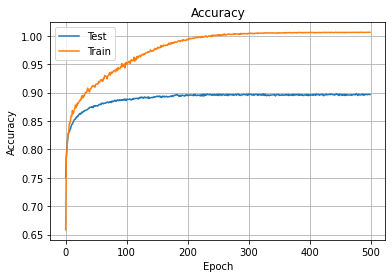

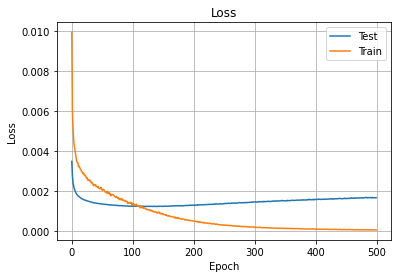

In [64]:
plot_data(
    data=[test_accuracy_lst, train_accuracy_lst],
    title="Accuracy",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Accuracy"
)
plot_data(
    data=[test_loss_lst, train_loss_lst],
    title="Loss",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Loss"
)

Видно, что модельначала переобучаться примерно на 100-й эпохе обучения, т.к. далее Loss на тесте повышался.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

Для исправления переобучения будем
1) Использовать L2 регуляризацию в SGD
2) Использовать Dropout слои
3) Добавим данных в обучающую выборку

Rem: количество слоев и параметров оставляем без изменений, т.к. задача - исправить модель, а не написать новую.

In [73]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Dropout(0.25),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Dropout(0.25),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Dropout(0.25),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Dropout(0.25),
            nn.Linear(2048, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [74]:
# torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

In [75]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [76]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 500
for t in range(epochs):
    train_accuracy, train_loss = train(train_loader, model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(test_loader, model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
        Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

Epoch: 1	Test Accuracy: 68.7%, Test Avg loss: 0.005627	        Train Accuracy: 40.4%, Train Avg loss: 0.014895
Epoch: 2	Test Accuracy: 72.5%, Test Avg loss: 0.004139	        Train Accuracy: 65.0%, Train Avg loss: 0.010294
Epoch: 3	Test Accuracy: 74.2%, Test Avg loss: 0.003487	        Train Accuracy: 70.0%, Train Avg loss: 0.008254
Epoch: 4	Test Accuracy: 75.0%, Test Avg loss: 0.003116	        Train Accuracy: 73.0%, Train Avg loss: 0.007156
Epoch: 5	Test Accuracy: 75.7%, Test Avg loss: 0.002894	        Train Accuracy: 74.8%, Train Avg loss: 0.006483
Epoch: 6	Test Accuracy: 76.4%, Test Avg loss: 0.002724	        Train Accuracy: 75.6%, Train Avg loss: 0.006010
Epoch: 7	Test Accuracy: 77.1%, Test Avg loss: 0.002599	        Train Accuracy: 76.1%, Train Avg loss: 0.005734
Epoch: 8	Test Accuracy: 77.4%, Test Avg loss: 0.002521	        Train Accuracy: 76.9%, Train Avg loss: 0.005540
Epoch: 9	Test Accuracy: 78.0%, Test Avg loss: 0.002445	        Train Accuracy: 77.6%, Train Avg loss: 0.005320
E

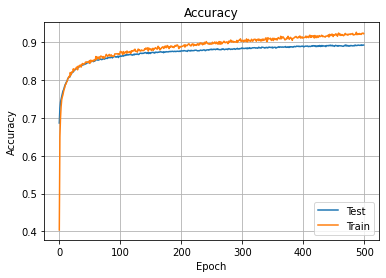

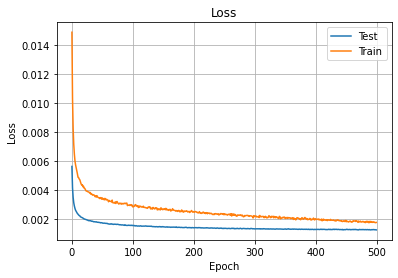

In [77]:
plot_data(
    data=[test_accuracy_lst, train_accuracy_lst],
    title="Accuracy",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Accuracy"
)
plot_data(
    data=[test_loss_lst, train_loss_lst],
    title="Loss",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Loss"
)

### Conclusions:

Из графиков выше видно, что после добавления L2 регуляризации, Dropout слоев и новых данных в обучающую выборку эффект переобучения не наблюдается. Показатели Loss на том же количестве эпох не возрастают на тестовой выборке.